In [ ]:
import os
import keras
import cv2
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
from glob import glob
from keras.models import Model
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MDP/Data.zip

In [ ]:
!unzip "/content/drive/MyDrive/MDP/test_final.zip"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (640, 480)
Input_Size = (640, 480,3)
BATCH_SIZE = 16
SEED = 0

def get_set():
    train_path = '/content/Data'
    test_path = "/content/test_final"
    train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_set = train_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE, \
                                              batch_size=BATCH_SIZE, seed=SEED, \
                                              subset='training',
                                            shuffle = False)
    val_set = train_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE, \
                                            batch_size=BATCH_SIZE, seed=SEED, \
                                            subset='validation',
                                            shuffle = False)

    test_gen = ImageDataGenerator(rescale=1./255)
    test_set = train_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE, \
                                             batch_size=BATCH_SIZE, seed=SEED,
                                            shuffle = False)
    
    return train_set, val_set, test_set

train_set, val_set, test_set = get_set()


Found 600 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Found 125 images belonging to 15 classes.


In [ ]:
model = tf.keras.models.Sequential([

tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding = 'same', input_shape=Input_Size),
#tf.keras.layers.MaxPooling2D(2, 2),

tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Flatten(),

tf.keras.layers.Dense(1024, activation='relu'),
tf.keras.layers.Dropout(0.01),
tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
tf.keras.layers.Dropout(0.01),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(32, activation='relu'),

tf.keras.layers.Dense(15, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])



In [ ]:
model.summary()

In [ ]:
file_path = "./Final1.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=8)
callbacks_list = [ checkpoint, reduce_on_plateau, es]

curr_model_hist = model.fit(
      train_set,
      callbacks=callbacks_list,
      epochs=500,
      validation_data=val_set,
      verbose=1)

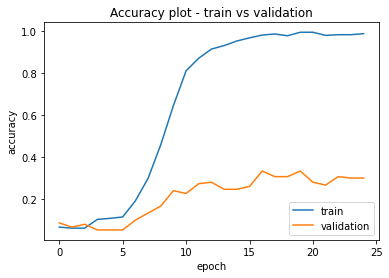

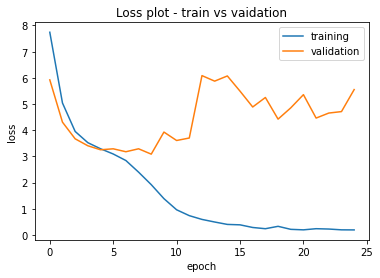

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['accuracy'])
        plt.plot(curr_model_hist.history['val_accuracy'])
        plt.legend(['train', 'validation'], loc='lower right')
        plt.title('Accuracy plot - train vs validation')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training', 'validation'], loc = 'upper right')
        plt.title('Loss plot - train vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)

In [ ]:
lossandacc = model.evaluate_generator(test_set,verbose=1)
print(lossandacc)

NameError: ignored

# Initializing Model Architectures 
## Included imagenet weights 

# Training using MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = MobileNetV2(input_shape=(224,224,3), include_top=False, \
                       pooling='max'
                       , weights='imagenet'
                       )
    base.trainable = False

    first = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(base.output)

    second = Dropout(0.01)(first)
    third = Dense(128, activation='relu')(second)
    final = Dense(32, activation='relu')(third)

    
    dense = Dense(15, activation='softmax', name='dense')(final)

    model = Model(inputs=base.inputs, outputs=dense, name='mobilenetv2')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.0001),
          metrics=['acc'])
    return model

mobilenet = get_model()

file_path = './mobilenet.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [ checkpoint, reduce_on_plateau, es]
hist = mobilenet.fit(train_set,
      callbacks=callbacks_list,
      epochs=100,
      validation_data=val_set,
      verbose=1)

In [ ]:
lossandacc = mobilenet.evaluate_generator(test_generator,verbose=1)
print(lossandacc)

32/32 [==============================] - 7s 228ms/step - loss: 0.4004 - acc: 0.8730
[0.4003580794669688, 0.873]


# Training using InceptionResNetV2

In [ ]:

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = InceptionResNetV2(input_shape=Input_Size, include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = True
    first = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(base.output)

    second = Dropout(0.01)(first)
    third = Dense(128, activation='relu')(second)
    final = Dense(32, activation='relu')(third)

    
    cool_dense = Dense(15, activation='softmax', name='cool_dense')(final)

    model = Model(inputs=base.inputs, outputs=cool_dense, name='mobilenetv2')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.0001),
          metrics=['acc'])
    return model

InceptionResNetV2 = get_model()

file_path = './InceptionResNetV2.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [ checkpoint, reduce_on_plateau, es]

hist = InceptionResNetV2.fit(train_set,
      callbacks=callbacks_list,
      epochs=500,
      validation_data=val_set,
      verbose=1)


Epoch 1/500
38/38 [==============================] - 96s 2s/step - loss: 11.6337 - acc: 0.0234 - val_loss: 10.0123 - val_acc: 0.0533

Epoch 00001: val_acc improved from -inf to 0.05333, saving model to ./InceptionResNetV2.h5
Epoch 2/500
38/38 [==============================] - 73s 2s/step - loss: 9.9060 - acc: 0.0753 - val_loss: 9.6807 - val_acc: 0.0533

Epoch 00002: val_acc did not improve from 0.05333
Epoch 3/500
38/38 [==============================] - 74s 2s/step - loss: 9.5694 - acc: 0.0843 - val_loss: 9.4017 - val_acc: 0.0667

Epoch 00003: val_acc improved from 0.05333 to 0.06667, saving model to ./InceptionResNetV2.h5
Epoch 4/500
38/38 [==============================] - 75s 2s/step - loss: 9.3618 - acc: 0.0502 - val_loss: 9.0767 - val_acc: 0.0933

Epoch 00004: val_acc improved from 0.06667 to 0.09333, saving model to ./InceptionResNetV2.h5
Epoch 5/500
38/38 [==============================] - 75s 2s/step - loss: 8.9909 - acc: 0.1590 - val_loss: 8.4318 - val_acc: 0.2600

Epoch 000

In [ ]:
Incep1 = get_model()
Incep1.load_weights('/content/drive/MyDrive/MDP/InceptionResNetV2_93.h5')
Incep2 = get_model()
Incep2.load_weights('/content/drive/MyDrive/MDP/InceptionResNetV2_90.h5')

In [ ]:
lossandacc = InceptionResNetV2.evaluate_generator(test_set,verbose=1)
print(lossandacc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


4/4 [==============================] - 3s 653ms/step - loss: 4.6159 - acc: 0.9120
[4.6158528327941895, 0.9120000004768372]


In [ ]:
def acc_cal(sample, leng):
  BATCH_SIZE = 32
  Y_pred1 = Incep1.predict_generator(sample, leng // BATCH_SIZE+1)
  Y_pred2 = Incep2.predict_generator(sample, leng // BATCH_SIZE+1)
  Y_pred = (Y_pred2 + Y_pred1)/2
  y_pred = np.argmax(Y_pred, axis=1)
  print('Confusion Matrix')
  conf = confusion_matrix(sample.classes, y_pred)
  print(accuracy_score(sample.classes, y_pred))
  print(conf)
acc_cal(val_set,150)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


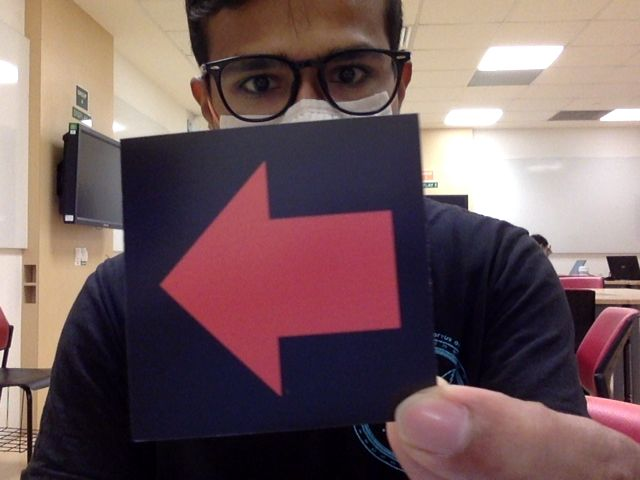

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
Y_pred1 = Incep1.predict_generator(val_set, 150 // BATCH_SIZE+1)
Y_pred2 = Incep2.predict_generator(val_set, 150 // BATCH_SIZE+1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
def acc_cal(lab):
  img = cv2.imread('/content/photo.jpg', cv2.IMREAD_UNCHANGED)
  dim = (480, 640)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('Resized Dimensions : ',resized.shape)
  Y_pred1 = Incep1.predict(resized)
  Y_pred2 = Incep2.predict(resized)
  Y_pred = (Y_pred2 + Y_pred1)/2
  y_pred = np.argmax(Y_pred, axis=1)
  print('Confusion Matrix')
  conf = confusion_matrix(lab, y_pred)
  print(accuracy_score(lab, y_pred))
  print(conf)
acc_cal(7)

NameError: ignored

Original Dimensions :  (480, 640, 3)
Resized Dimensions :  (224, 224, 3)


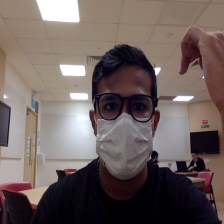

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/photo.jpg', cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
 
scale_percent = 60 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (224, 224)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2_imshow( resized)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Training using ResNet152

In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = ResNet152(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = True
    first = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(base.output)

    second = Dropout(0.01)(first)
    third = Dense(128, activation='relu')(second)
    final = Dense(32, activation='relu')(third)

    
    cool_dense = Dense(15, activation='softmax', name='cool_dense')(final)

    model = Model(inputs=base.inputs, outputs=cool_dense, name='mobilenetv2')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.0001),
          metrics=['acc'])
    return model

ResNet152 = get_model()

file_path = './ResNet152.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [ checkpoint, reduce_on_plateau, es]
hist = ResNet152.fit(train_set,
      callbacks=callbacks_list,
      epochs=100,
      validation_data=val_set,
      verbose=1)

Epoch 1/100
19/19 [==============================] - 36s 1s/step - loss: 16.5689 - acc: 0.0424 - val_loss: 11.4569 - val_acc: 0.0667

Epoch 00001: val_acc improved from -inf to 0.06667, saving model to ./ResNet152.h5
Epoch 2/100
19/19 [==============================] - 18s 935ms/step - loss: 11.3045 - acc: 0.1120 - val_loss: 10.8918 - val_acc: 0.0600

Epoch 00002: val_acc did not improve from 0.06667
Epoch 3/100
19/19 [==============================] - 18s 920ms/step - loss: 10.8074 - acc: 0.1528 - val_loss: 11.2419 - val_acc: 0.0667

Epoch 00003: val_acc did not improve from 0.06667
Epoch 4/100
19/19 [==============================] - 18s 922ms/step - loss: 10.4188 - acc: 0.2064 - val_loss: 11.3130 - val_acc: 0.0667

Epoch 00004: val_acc did not improve from 0.06667
Epoch 5/100
19/19 [==============================] - 18s 934ms/step - loss: 10.3020 - acc: 0.2681 - val_loss: 11.0057 - val_acc: 0.0667

Epoch 00005: val_acc did not improve from 0.06667
Epoch 6/100
19/19 [================

In [ ]:
lossandacc = ResNet152.evaluate_generator(test_set,verbose=1)
print(lossandacc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


4/4 [==============================] - 2s 541ms/step - loss: 9.9076 - acc: 0.1280
[9.907570838928223, 0.12800000607967377]


In [ ]:
Y_pred = ResNet152.predict_generator(test_set, 125 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf = confusion_matrix(test_set.classes, y_pred)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


In [ ]:
conf

array([[ 3,  0,  0,  3,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  2,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  5,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  2,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  3,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0

# Training using VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = VGG19(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = True
    first = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(base.output)

    second = Dropout(0.01)(first)
    third = Dense(128, activation='relu')(second)
    final = Dense(32, activation='relu')(third)

    
    cool_dense = Dense(15, activation='softmax', name='cool_dense')(final)

    model = Model(inputs=base.inputs, outputs=cool_dense, name='VGG19')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model  

VGG19 = get_model()

file_path = './VGG19.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [ checkpoint, reduce_on_plateau, es]
hist = VGG19.fit(train_set,
      callbacks=callbacks_list,
      epochs=100,
      validation_data=val_set,
      verbose=1)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/100
19/19 [==============================] - 13s 506ms/step - loss: 55.8722 - acc: 0.0336 - val_loss: 6.3084 - val_acc: 0.0667

Epoch 00001: val_acc improved from -inf to 0.06667, saving model to ./VGG19.h5
Epoch 2/100
19/19 [==============================] - 7s 386ms/step - loss: 6.0189 - acc: 0.0537 - val_loss: 5.3225 - val_acc: 0.0667

Epoch 00002: val_acc did not improve from 0.06667
Epoch 3/100
19/19 [==============================] - 7s 383ms/step - loss: 5.1753 - acc: 0.0258 - val_loss: 4.7902 - val_acc: 0.0667

Epoch 00003: val_acc did not improve from 0.06667
Epoch 4/100
19/19 [==============================] - 7s 382ms/step - loss: 4.7138 - acc: 0.0247 - val_loss: 4.4922 - val_acc: 0.0667

Epoch 00004: val_acc did not improve from 0.06667
Epoch 5/100
19/19 [==============================] - 7s 382ms/step - loss: 4.4855 - acc: 0.0647 - val_loss: 4.3156 - val_acc: 0.0667

Epoch 00005: val_acc did not impro

In [ ]:
lossandacc = VGG19.evaluate_generator(test_generator,verbose=1)
print(lossandacc)

32/32 [==============================] - 8s 261ms/step - loss: 0.3346 - acc: 0.8505
[0.3346271039918065, 0.8505]


# Training using ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def get_model():
    base = ResNet50(input_shape=(224,224,3), include_top=False, \
                       pooling='max', weights='imagenet')
    base.trainable = True
    first = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(base.output)

    second = Dropout(0.01)(first)
    third = Dense(128, activation='relu')(second)
    final = Dense(32, activation='relu')(third)

    
    cool_dense = Dense(15, activation='softmax', name='cool_dense')(final)

    model = Model(inputs=base.inputs, outputs=cool_dense, name='mobilenetv2')
    model.compile(loss='categorical_crossentropy',
          optimizer=Adam(lr=0.001),
          metrics=['acc'])
    return model

ResNet50 = get_model()

file_path = './ResNet50.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=5, verbose=1)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
callbacks_list = [ checkpoint, reduce_on_plateau, es]
hist = ResNet50.fit(train_set,
      callbacks=callbacks_list,
      epochs=100,
      validation_data=val_set,
      verbose=1)

Epoch 1/100
19/19 [==============================] - 14s 479ms/step - loss: 25.3565 - acc: 0.0329 - val_loss: 10.2665 - val_acc: 0.0667

Epoch 00001: val_acc improved from -inf to 0.06667, saving model to ./ResNet50.h5
Epoch 2/100
19/19 [==============================] - 8s 427ms/step - loss: 10.1397 - acc: 0.0150 - val_loss: 9.6686 - val_acc: 0.0667

Epoch 00002: val_acc did not improve from 0.06667
Epoch 3/100
19/19 [==============================] - 9s 475ms/step - loss: 9.5432 - acc: 0.0000e+00 - val_loss: 9.1844 - val_acc: 0.0667

Epoch 00003: val_acc did not improve from 0.06667
Epoch 4/100
19/19 [==============================] - 8s 423ms/step - loss: 9.0962 - acc: 0.0259 - val_loss: 8.7683 - val_acc: 0.0667

Epoch 00004: val_acc did not improve from 0.06667
Epoch 5/100
19/19 [==============================] - 8s 426ms/step - loss: 8.6715 - acc: 0.0947 - val_loss: 8.3974 - val_acc: 0.0667

Epoch 00005: val_acc did not improve from 0.06667
Epoch 6/100
19/19 [=====================

In [ ]:
lossandacc = ResNet50.evaluate_generator(test_set,verbose=1)
print(lossandacc)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


4/4 [==============================] - 2s 481ms/step - loss: 5.6806 - acc: 0.0640
[5.680646896362305, 0.06400000303983688]


In [ ]:
Y_pred = ResNet50.predict_generator(train_set, 600 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf = confusion_matrix(train_set.classes, y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


In [ ]:
conf

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40],
       [ 0,  0,  0,  0,  0,  0,  0